#1.Data Processing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
import glob as gb
import cv2
import tensorflow as tf
import keras
import os
from sklearn.metrics import confusion_matrix


**1. importing data from kaggle**

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip -d intel_data



Streaming output truncated to the last 5000 lines.
  inflating: intel_data/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7

<div style="text-align: center; font-size: 24px; font-weight: bold; color: #FFFFFF; padding: 20px; background-color: #4A90E2; border-radius: 10px;">
  Import Data And Preprocessing
</div>


**2.Assigning Paths**

In [ ]:
train_path = '/content/intel_data/seg_train/'
test_path = '/content/intel_data/seg_test/'
pred_path = '/content/intel_data/seg_pred/'

**3. Checking Images Present in Each Category**

In [ ]:
def open_folders(path, file, name = 'Traning Data'):
    for folder in os.listdir(path + file):
        files = gb.glob(pathname = path + file + '/' + folder + '/*.jpg')
        print(f'For {name} : Found {len(files)} images in folder {folder}')

print('-' * 40 + ' Traning Data ' + '-' * 46)
open_folders(train_path, 'seg_train')
print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
open_folders(test_path, 'seg_test', name = 'Test Data')
print('\n' +'-' * 40 + ' Prediction Data ' + '-' * 44)
files = gb.glob(pathname = pred_path + 'seg_pred' + '/*.jpg')
print(f'For Prediction Data : Found {len(files)} images in folder Prediction')

---------------------------------------- Traning Data ----------------------------------------------
For Traning Data : Found 2274 images in folder sea
For Traning Data : Found 2404 images in folder glacier
For Traning Data : Found 2271 images in folder forest
For Traning Data : Found 2512 images in folder mountain
For Traning Data : Found 2191 images in folder buildings
For Traning Data : Found 2382 images in folder street

---------------------------------------- Test Data --------------------------------------------------
For Test Data : Found 510 images in folder sea
For Test Data : Found 553 images in folder glacier
For Test Data : Found 474 images in folder forest
For Test Data : Found 525 images in folder mountain
For Test Data : Found 437 images in folder buildings
For Test Data : Found 501 images in folder street

---------------------------------------- Prediction Data --------------------------------------------
For Prediction Data : Found 7301 images in folder Prediction


**4.Checking The Image Shape**

In [ ]:
def get_image_size(path, folder_name):
    size = []
    if folder_name != 'seg_pred':
        for folder in os.listdir(path + folder_name):
            files = gb.glob(pathname = path + folder_name + '/' + folder + '/*.jpg')
            for file in files:
                image = plt.imread(file)
                size.append(image.shape)
    else:
        files = gb.glob(pathname = path + folder_name + '/*.jpg')
        for file in files:
            image = plt.imread(file)
            size.append(image.shape)

    print(pd.Series(size).value_counts())

print('-' * 40 + ' Traning Data ' + '-' * 46)
get_image_size(train_path, 'seg_train')
print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
get_image_size(test_path, 'seg_test')
print('\n' +'-' * 40 + ' Prediction Data ' + '-' * 44)
get_image_size(pred_path, 'seg_pred')


---------------------------------------- Traning Data ----------------------------------------------
(150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(108, 150, 3)        2
(144, 150, 3)        2
(123, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(142, 150, 3)        2
(143, 150, 3)        2
(136, 150, 3)        2
(141, 150, 3)        1
(115, 150, 3)        1
(145, 150, 3)        1
(103, 150, 3)        1
(100, 150, 3)        1
(81, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(149, 150, 3)        1
(133, 150, 3)        1
(102, 150, 3)        1
(105, 150, 3)        1
(120, 150, 3)        1
(76, 150, 3)         1
(119, 150, 3)        1
(97, 150, 3)         1
(110, 150, 3)        1
(140, 150, 3)        1
(124, 150, 3)        1
Name: count, dtype: int64

---------------------------------------- Test Data --------------------------------------------------
(150, 150, 3)    2993
(76, 150, 3)        1
(72, 150, 3) 

<div style="font-size: 18px; color: #333; padding: 20px; background-color: #f9f9f9; border-left: 5px solid #4A90E2; border-radius: 8px; line-height: 1.6;">
  Most of the images are sized <strong>150x150x3</strong>, and they need to be uniform in size for the model, which only accepts input in one specific dimension. To avoid losing significant information, we will resize them to <strong>100x100x3</strong>.
</div>


**5.Assigning Labels**

In [ ]:
# Get Image In Arrays And Resize Images
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_name(code_number):
    for key, value in code.items():
        if code_number == value:
            return key

In [ ]:
new_size = 100
def get_image_array(path, folder_name, new_size = new_size):
    X = []
    y = []
    if folder_name != 'seg_pred':
        for folder in os.listdir(path + folder_name):
            files = gb.glob(pathname= path + folder_name + '/' + folder + '/*.jpg')
            for file in files:
                image = cv2.imread(file)
                image_array = cv2.resize(image, (new_size, new_size))
                X.append(list(image_array))
                y.append(code[folder])
    else :
        files = gb.glob(pathname= path + folder_name + '/*.jpg')
        for file in files:
            image = cv2.imread(file)
            image_array = cv2.resize(image, (new_size, new_size))
            X.append(list(image_array))
    return X, y

In [ ]:
X_train, y_train = get_image_array(train_path, 'seg_train')
X_test, y_test = get_image_array(test_path, 'seg_test')

print('-' * 40 + ' Traning Data ' + '-' * 46)
print(f'We Have {len(X_train)} Image In X_train')
print(f'We Have {len(y_train)} items In y_train ')

print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
print(f'We Have {len(X_test)} Image In X_test')
print(f'We Have {len(y_test)} items In y_test')


---------------------------------------- Traning Data ----------------------------------------------
We Have 14034 Image In X_train
We Have 14034 items In y_train 

---------------------------------------- Test Data --------------------------------------------------
We Have 3000 Image In X_test
We Have 3000 items In y_test


**6. Plotting Images After Assigning Lables**

In [ ]:
def plot_some_image(X, y, name):
    print('-' * 77 + f' {name} Data ' + '-' * 77)
    plt.figure(figsize = (30, 40))
    for n, i in enumerate(list(np.random.randint(0, len(X), 36))):
        plt.subplot(6, 6, n+1)
        plt.imshow(X[i])
        plt.axis('off')
        if name != 'Prediction':
            plt.title(get_name(y[i]), fontdict = {'fontsize': 14, 'color': 'red'})


**Train Data**

----------------------------------------------------------------------------- Traning Data -----------------------------------------------------------------------------


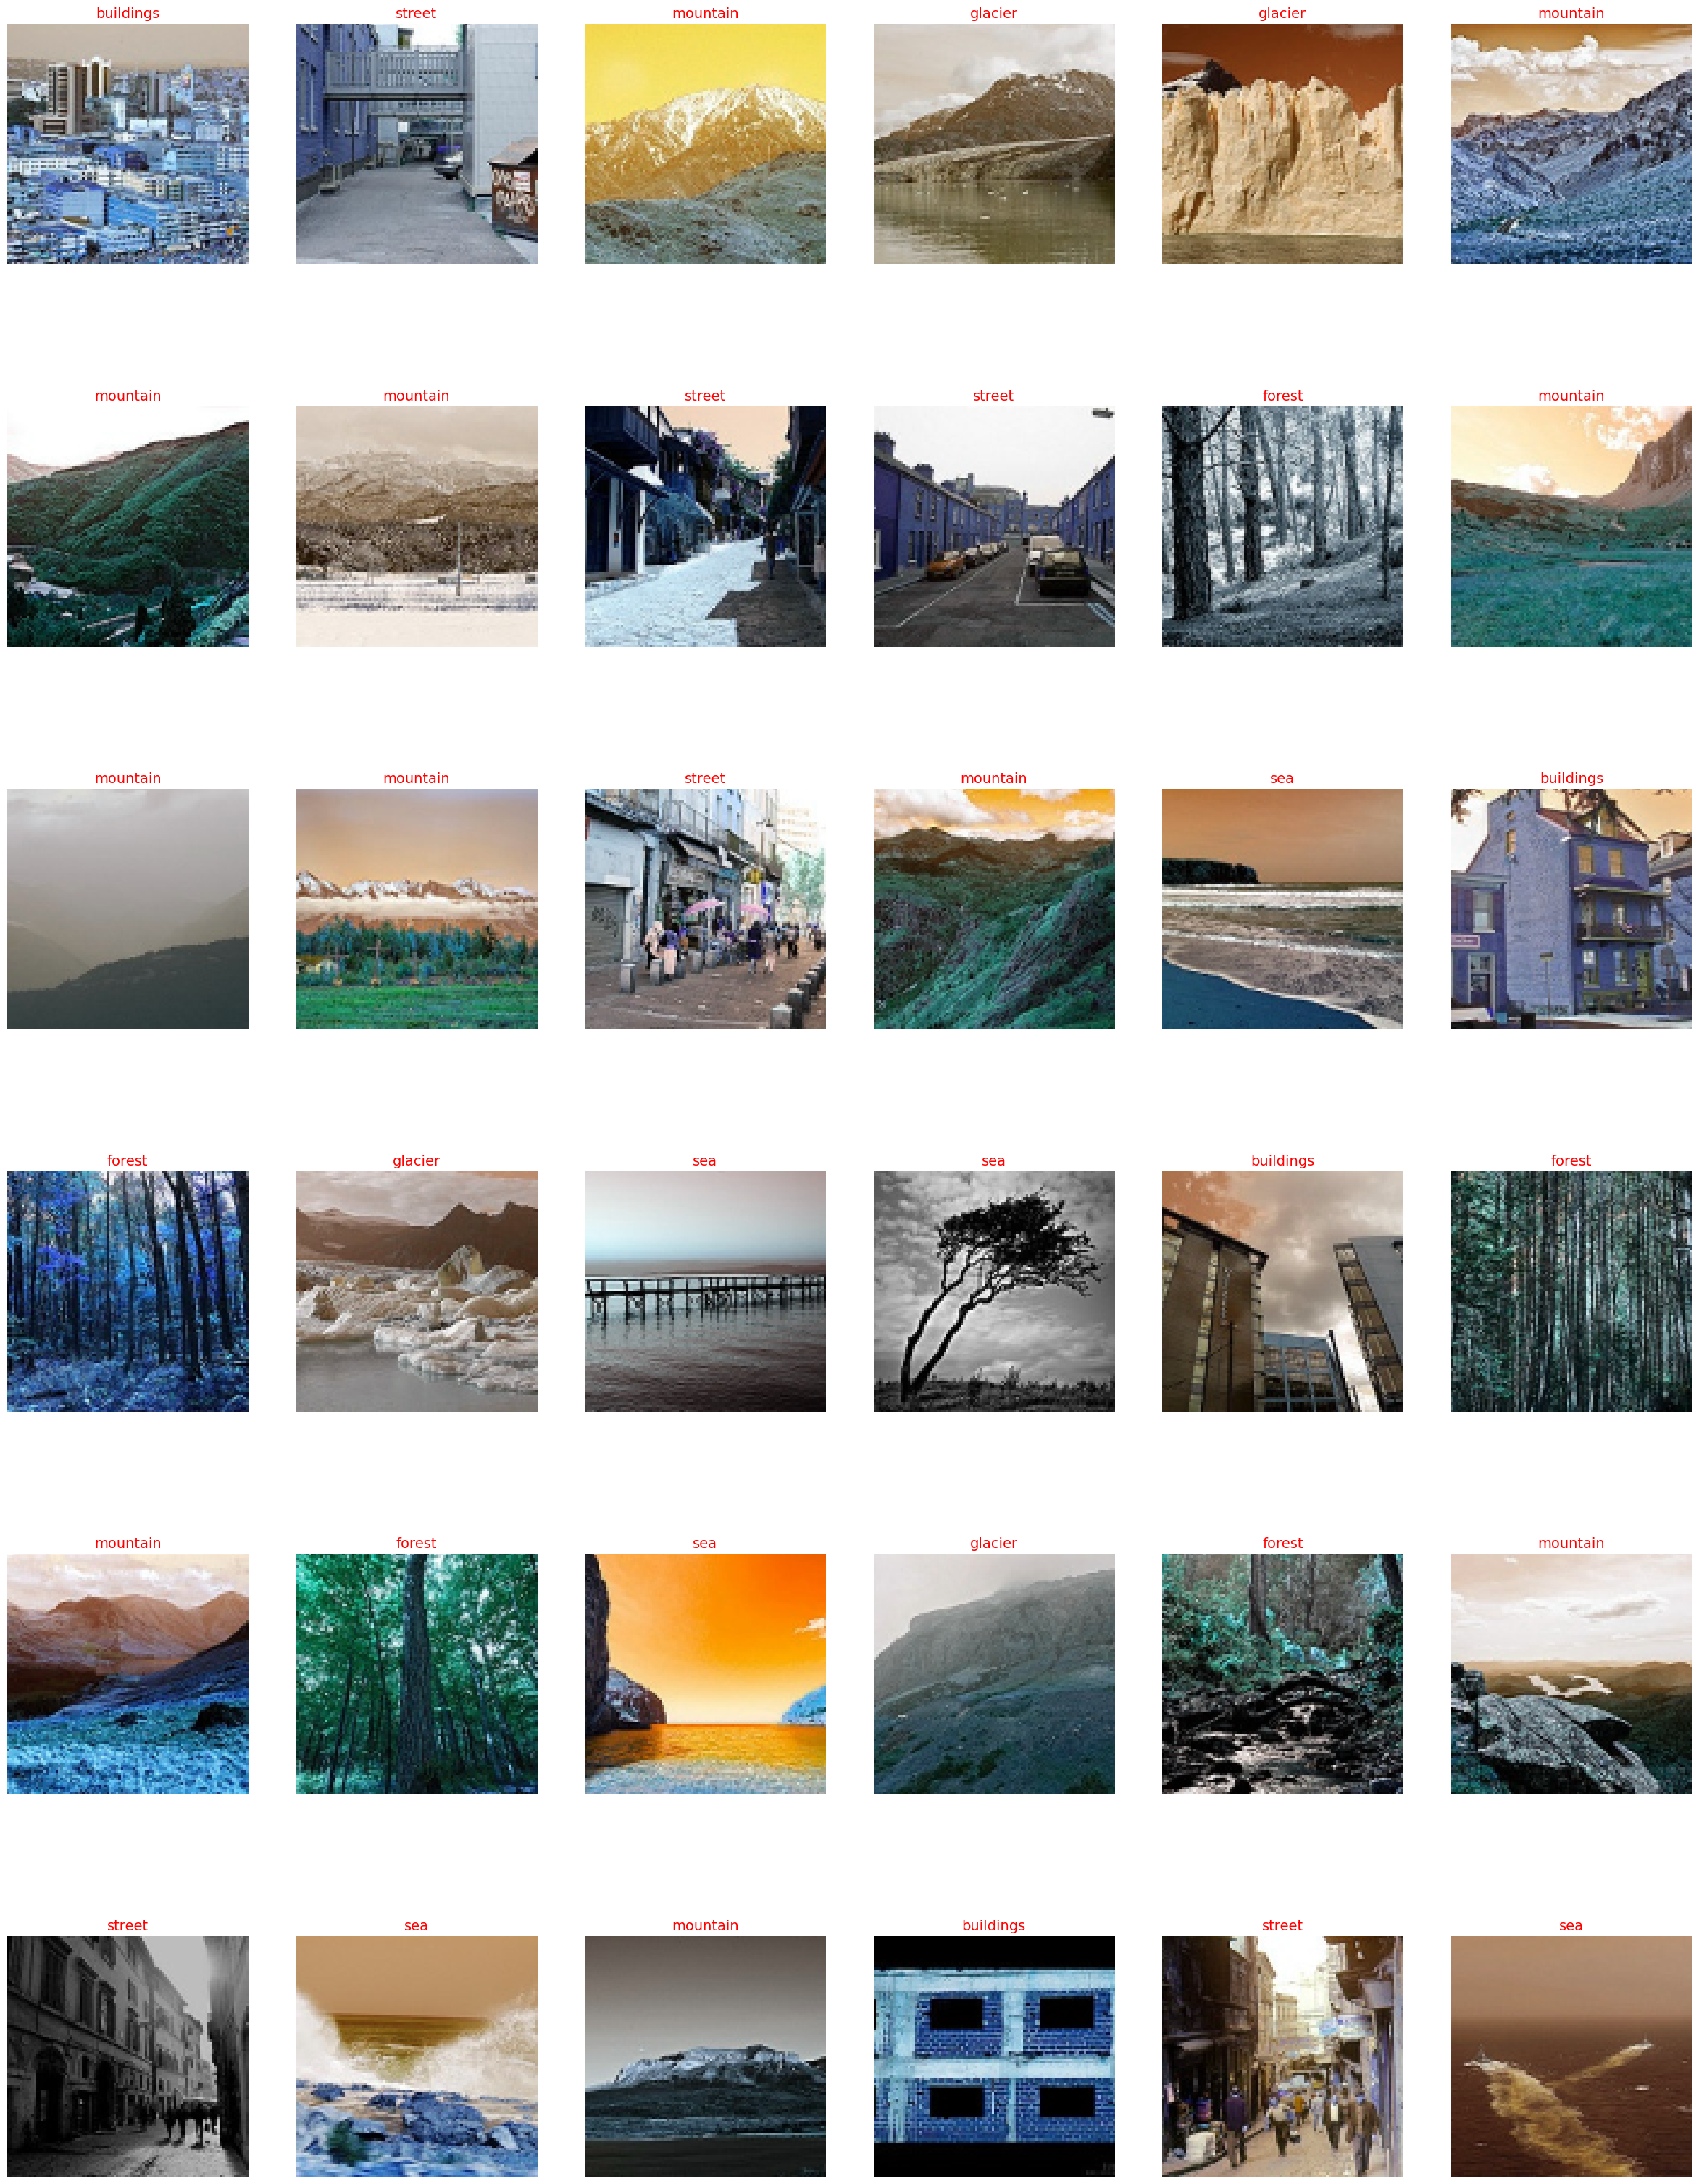

In [ ]:
plot_some_image(X_train, y_train, name = 'Traning')

**Test Data**

----------------------------------------------------------------------------- Test Data -----------------------------------------------------------------------------


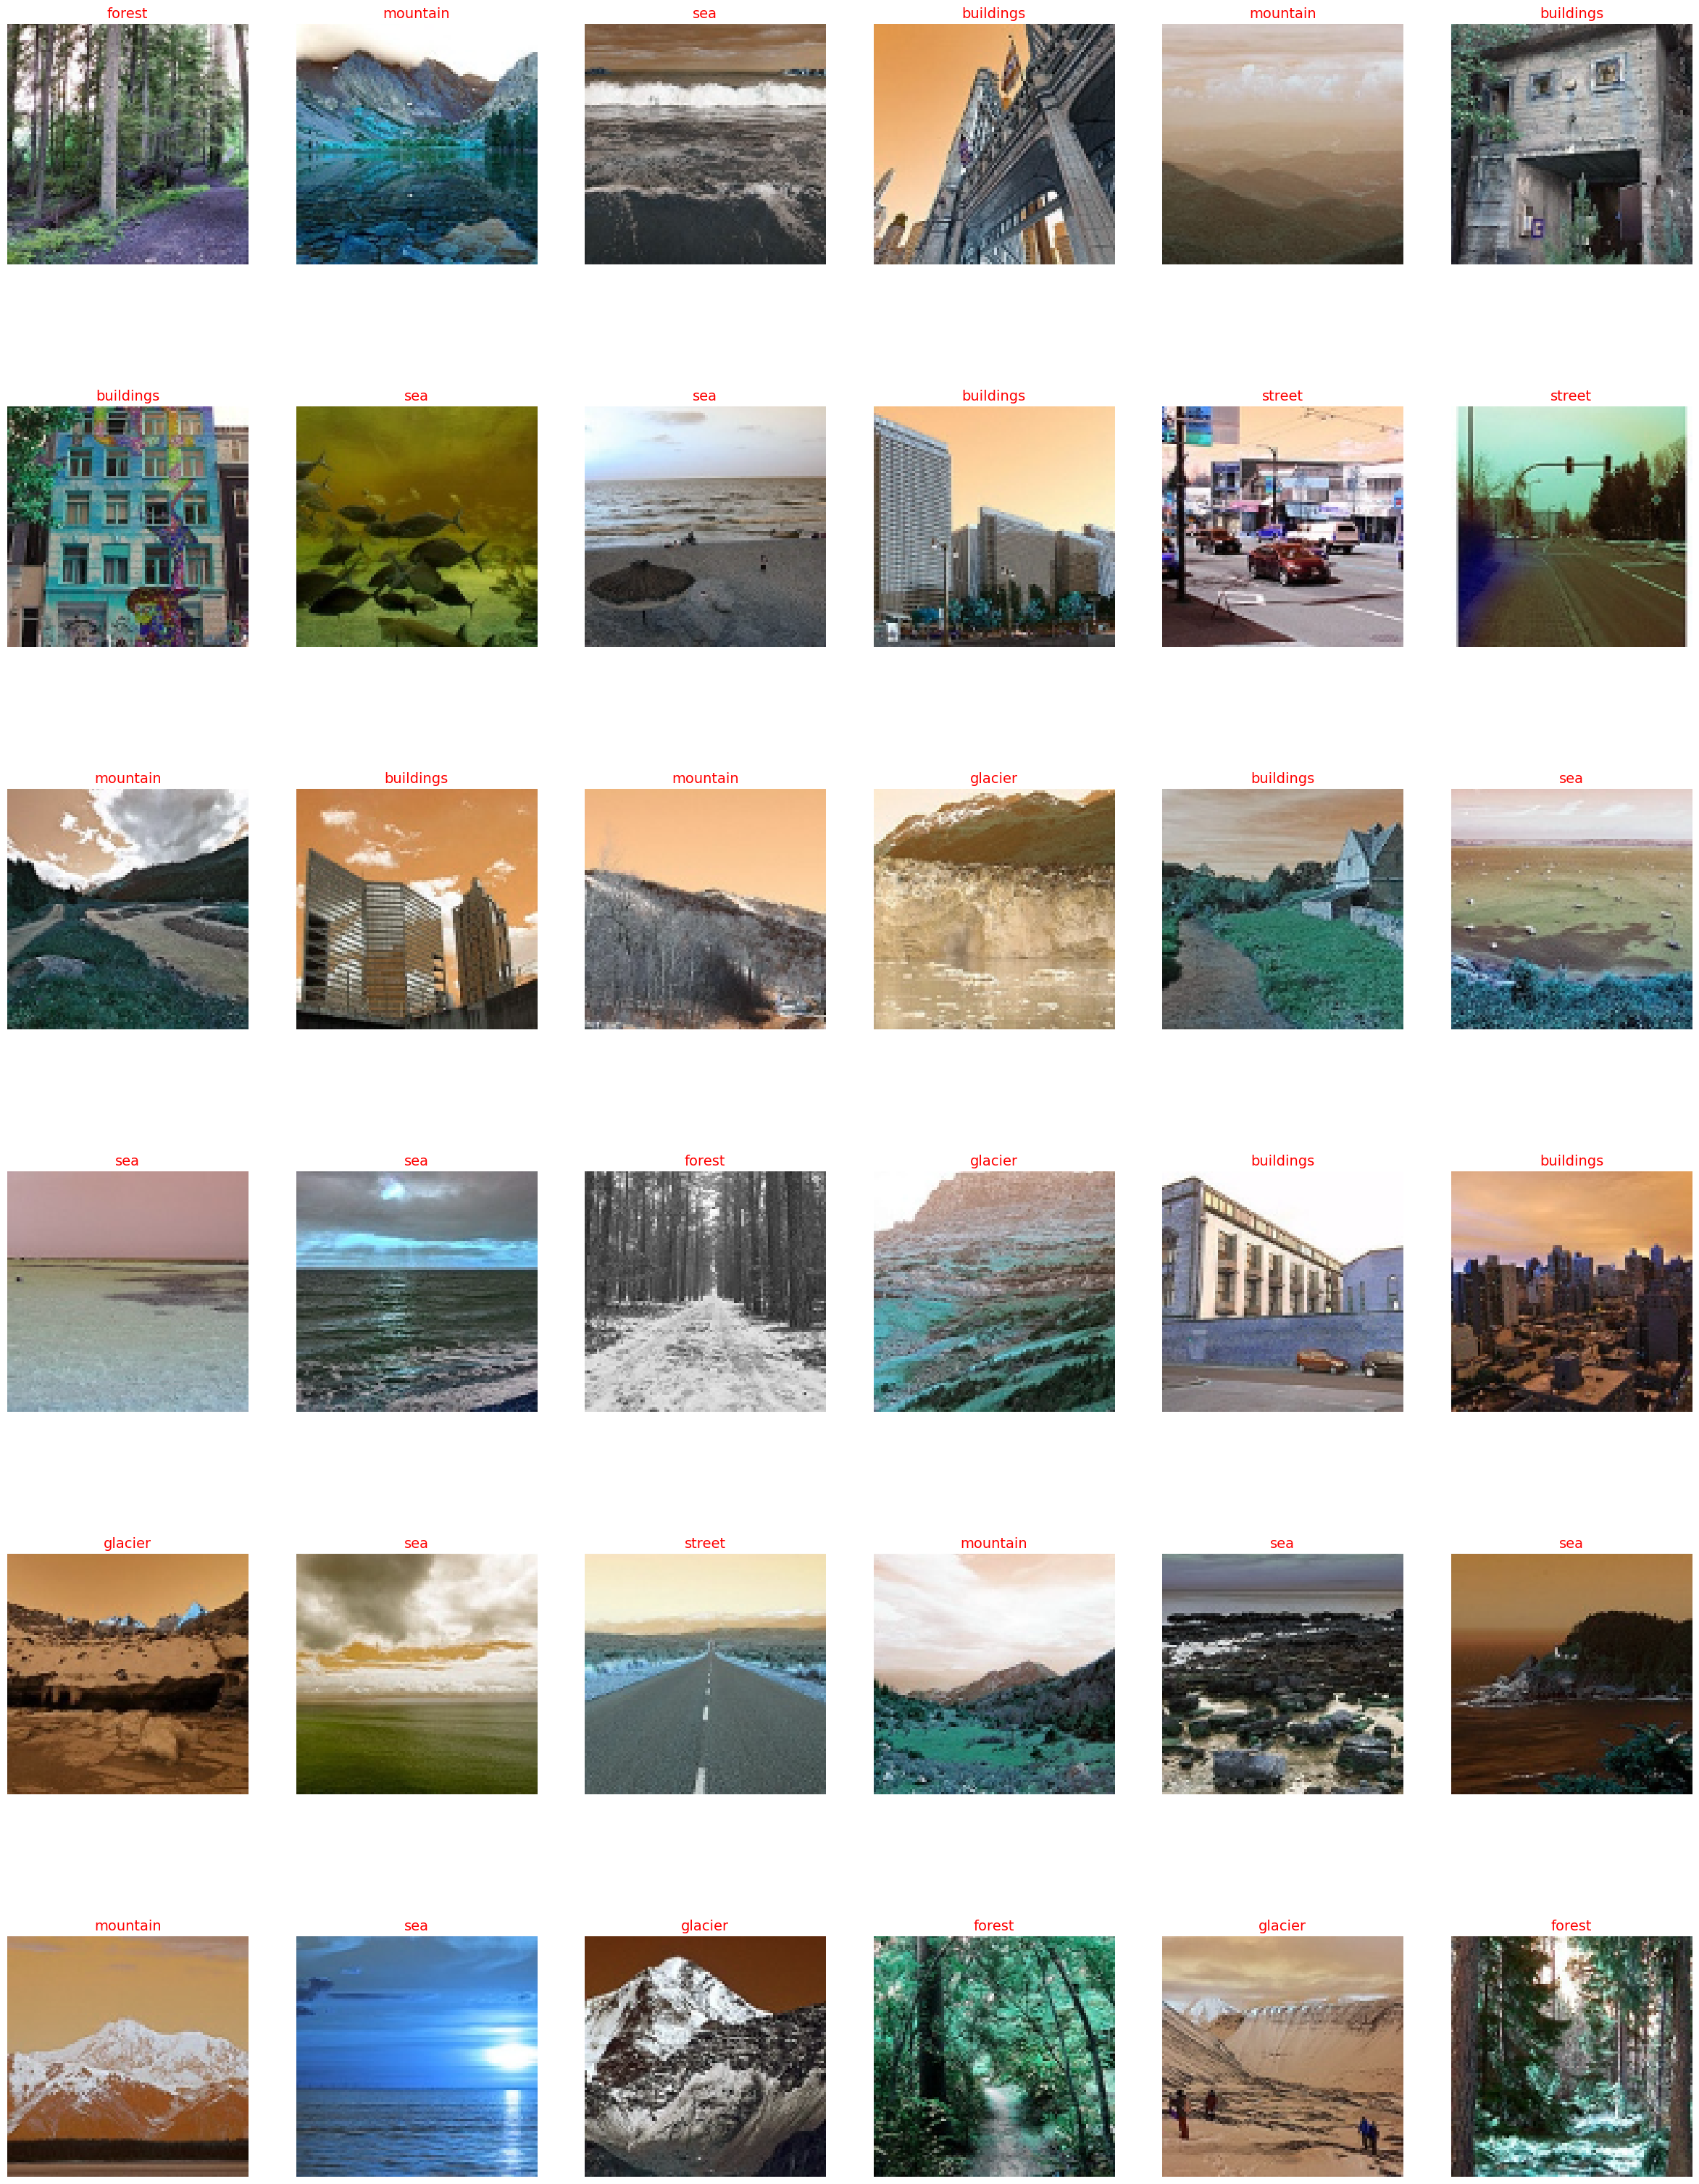

In [ ]:
plot_some_image(X_test, y_test, 'Test')

**Prediction Data**

----------------------------------------------------------------------------- Prediction Data -----------------------------------------------------------------------------


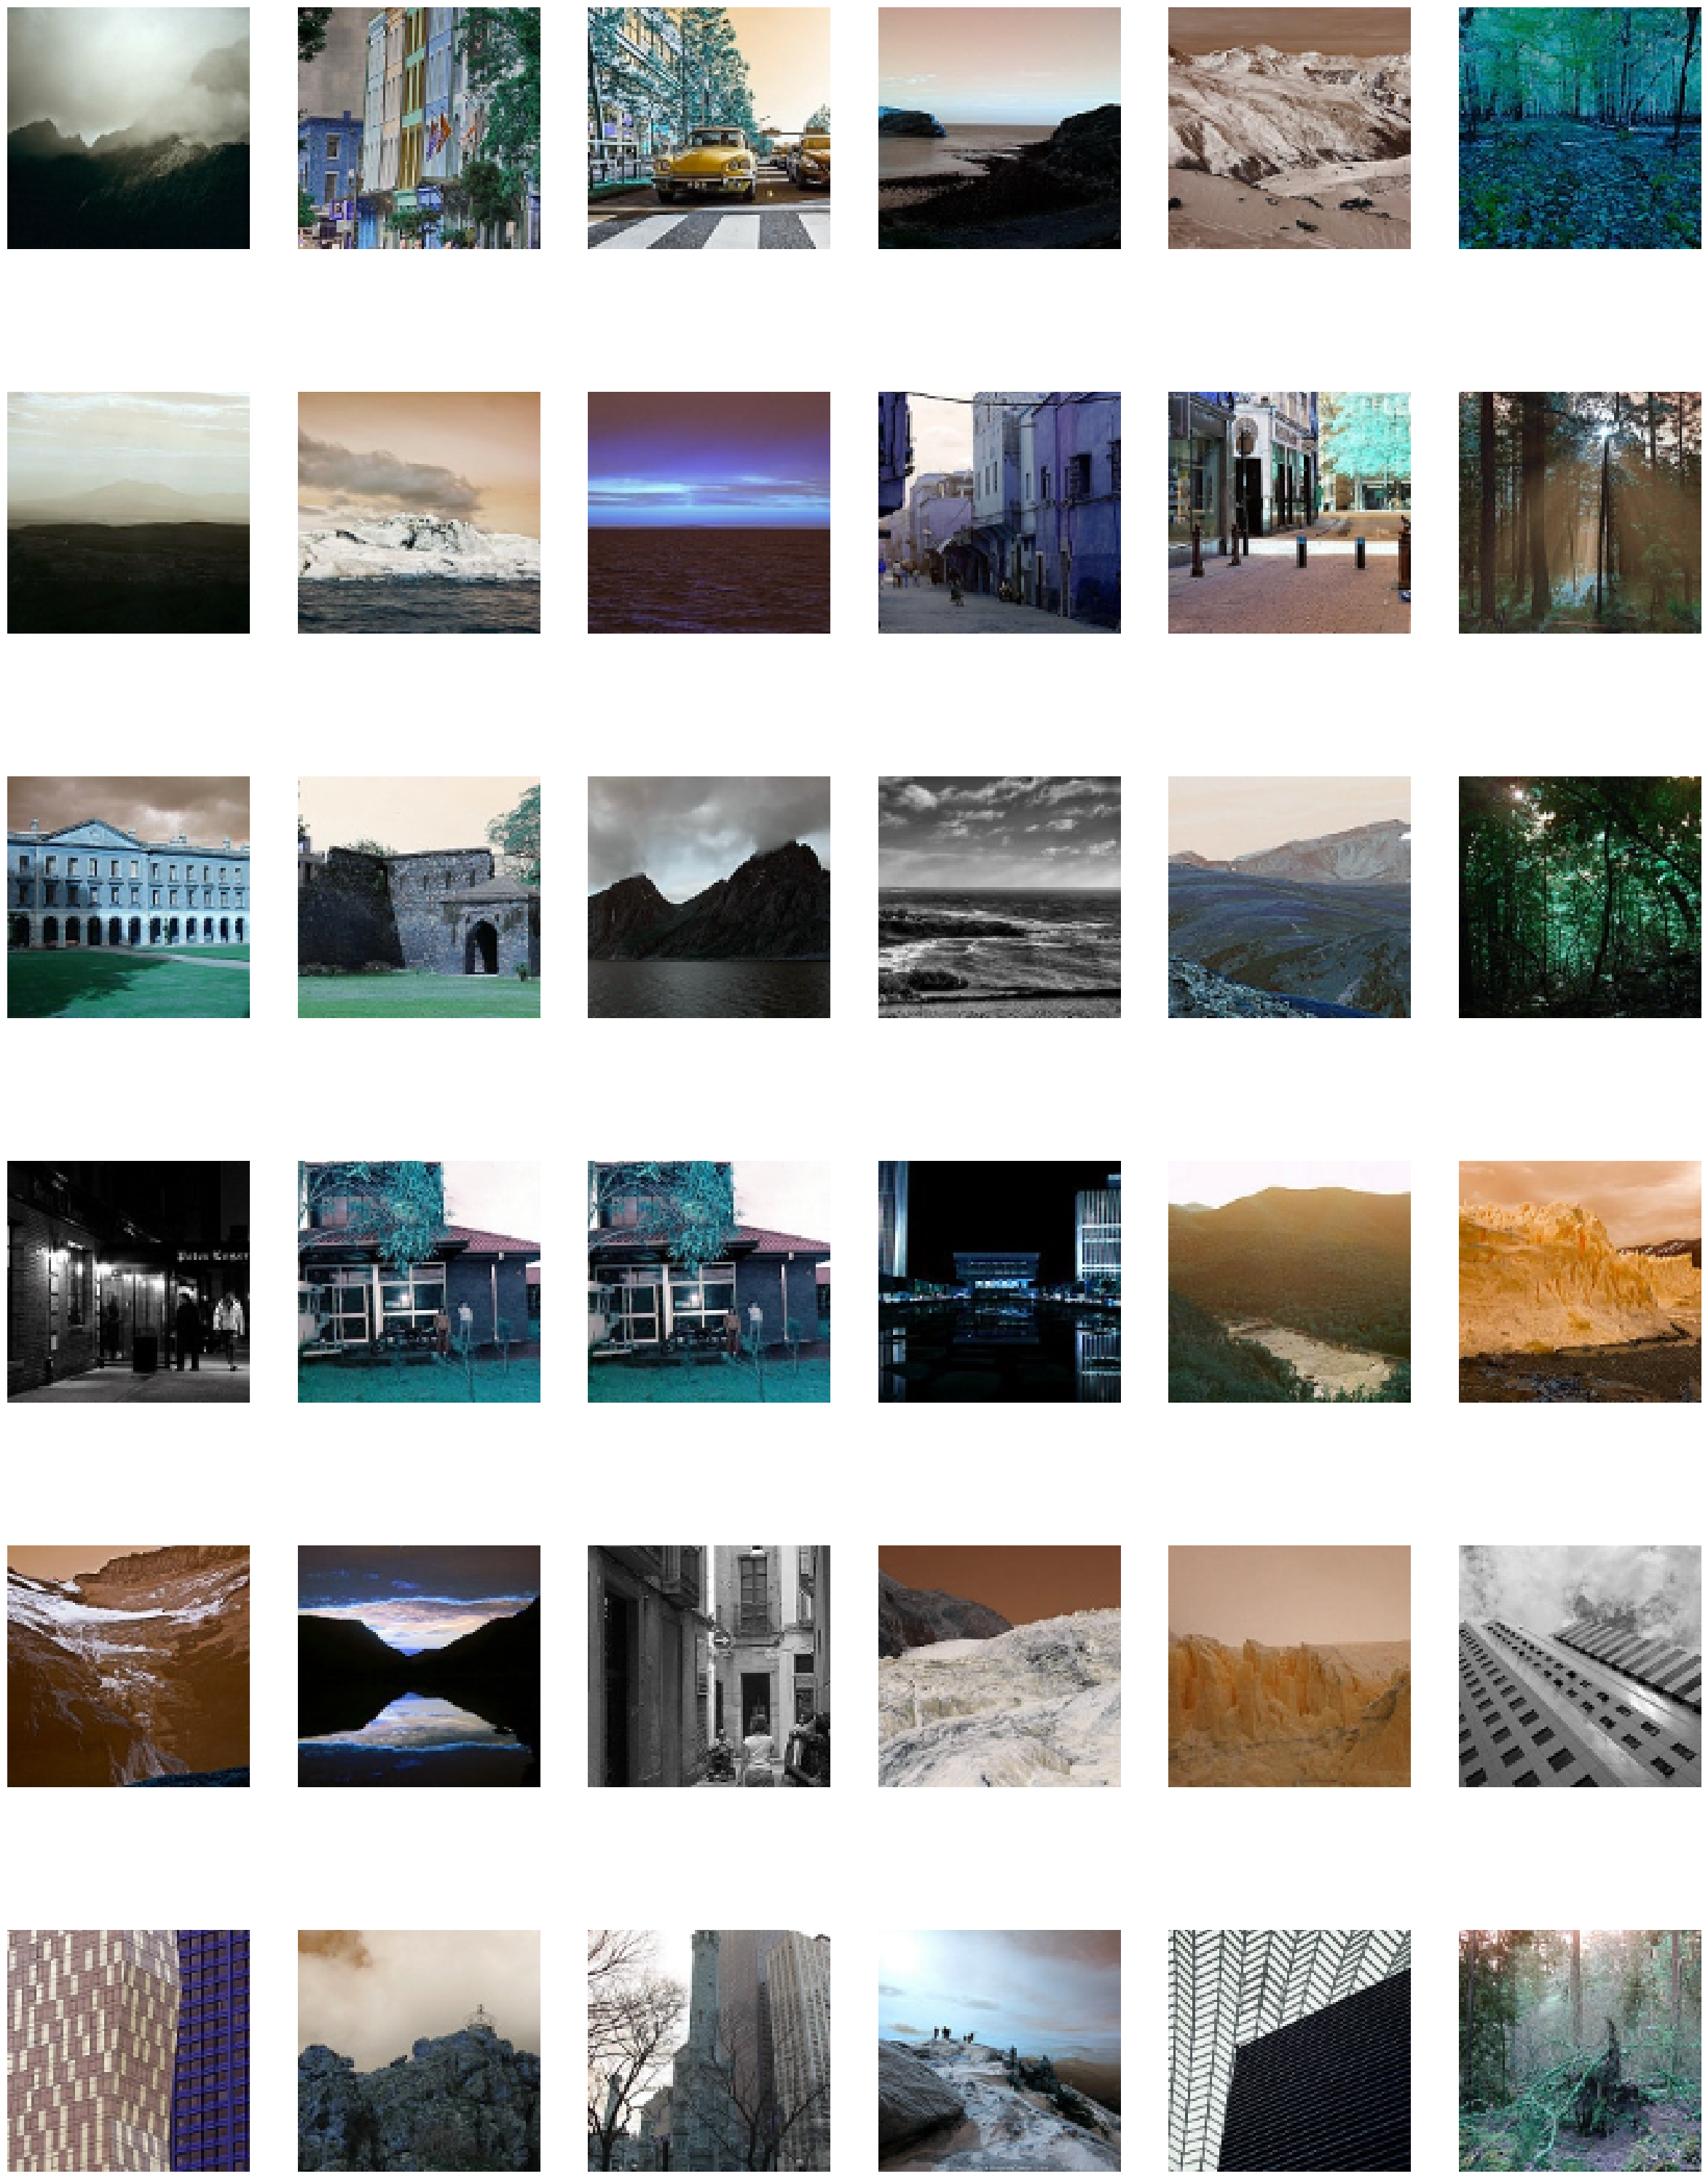

In [ ]:
plot_some_image(X_pred, None, 'Prediction')

#Converting Images into Graphs Using Delaunay Traingle

**Importing Torch Geometric Library**

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00


**1.Function to convert an image to a graph**

In [ ]:
import os
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torch_geometric.data import Data
from scipy.spatial import Delaunay
from skimage.transform import resize
from torch_geometric.loader import DataLoader
from torch.nn import Linear, ReLU
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool

def image_to_graph(image, new_size=(32, 32)):
    image = np.array(image)  # Ensure the image is a NumPy array
    h, w, c = image.shape
    image = resize(image, new_size, anti_aliasing=True)
    pixels = image.reshape(-1, c)
    positions = np.column_stack(np.unravel_index(np.arange(new_size[0] * new_size[1]), (new_size[0], new_size[1])))
    tri = Delaunay(positions)
    edges = [(simplex[i], simplex[(i + 1) % 3]) for simplex in tri.simplices for i in range(3)]
    edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)
    x = torch.tensor(pixels, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

def convert_dataset_to_graph(X, y=None):
    graphs = []
    for i, image in enumerate(X):
        graph = image_to_graph(image)
        if y is not None:
            graph.y = torch.tensor(y[i], dtype=torch.long)
        graphs.append(graph)
    return graphs

train_graphs = convert_dataset_to_graph(X_train, y_train)
test_graphs = convert_dataset_to_graph(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

#2. Model Building

**1. Defining the GCN model**

In [ ]:

class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dims[0])
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])
        self.batch_norm1 = BatchNorm(hidden_dims[1])
        self.conv3 = GCNConv(hidden_dims[1], hidden_dims[2])
        self.batch_norm2 = BatchNorm(hidden_dims[2])
        self.fc = Linear(hidden_dims[2], num_classes)
        self.relu = ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.batch_norm1(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.batch_norm2(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

input_dim = 3  # RGB channels
hidden_dims = [256, 128, 64]  # Simplified
num_classes = len(code)

model = GCNModel(input_dim, hidden_dims, num_classes)


**2.Training and validation functions**

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate():
    model.eval()
    correct = 0
    for data in test_loader:
        out = model(data)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(test_graphs)

**3.Training the model**

In [ ]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train()
    val_acc = validate()
    print(f'Epoch {epoch}, Loss: {train_loss:.4f}, Validation Accuracy: {val_acc:.4f}')


Epoch 1, Loss: 1.2271, Validation Accuracy: 0.5040
Epoch 2, Loss: 1.2118, Validation Accuracy: 0.5030
Epoch 3, Loss: 1.2045, Validation Accuracy: 0.5213
Epoch 4, Loss: 1.1974, Validation Accuracy: 0.5030
Epoch 5, Loss: 1.1910, Validation Accuracy: 0.5273
Epoch 6, Loss: 1.1862, Validation Accuracy: 0.4757
Epoch 7, Loss: 1.1844, Validation Accuracy: 0.5057
Epoch 8, Loss: 1.1801, Validation Accuracy: 0.5357
Epoch 9, Loss: 1.1771, Validation Accuracy: 0.5120
Epoch 10, Loss: 1.1699, Validation Accuracy: 0.5337


#3.Evaluation and Results

**1. Evaluating the Model**

In [ ]:
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total

    return avg_loss, accuracy

# Evaluate the model
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print('Test Loss is {:.4f}'.format(test_loss))
print('Test Accuracy is {:.4f}'.format(test_accuracy))


Test Loss is 1.1974
Test Accuracy is 0.5337


In [ ]:
model.eval()
all_outputs = []
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        all_outputs.append(out)
y_test_pred = torch.cat(all_outputs, dim=0)
print(f'Prediction Shape is {y_test_pred.shape}')

Prediction Shape is torch.Size([3000, 6])


**2.Plotting the prediction results**

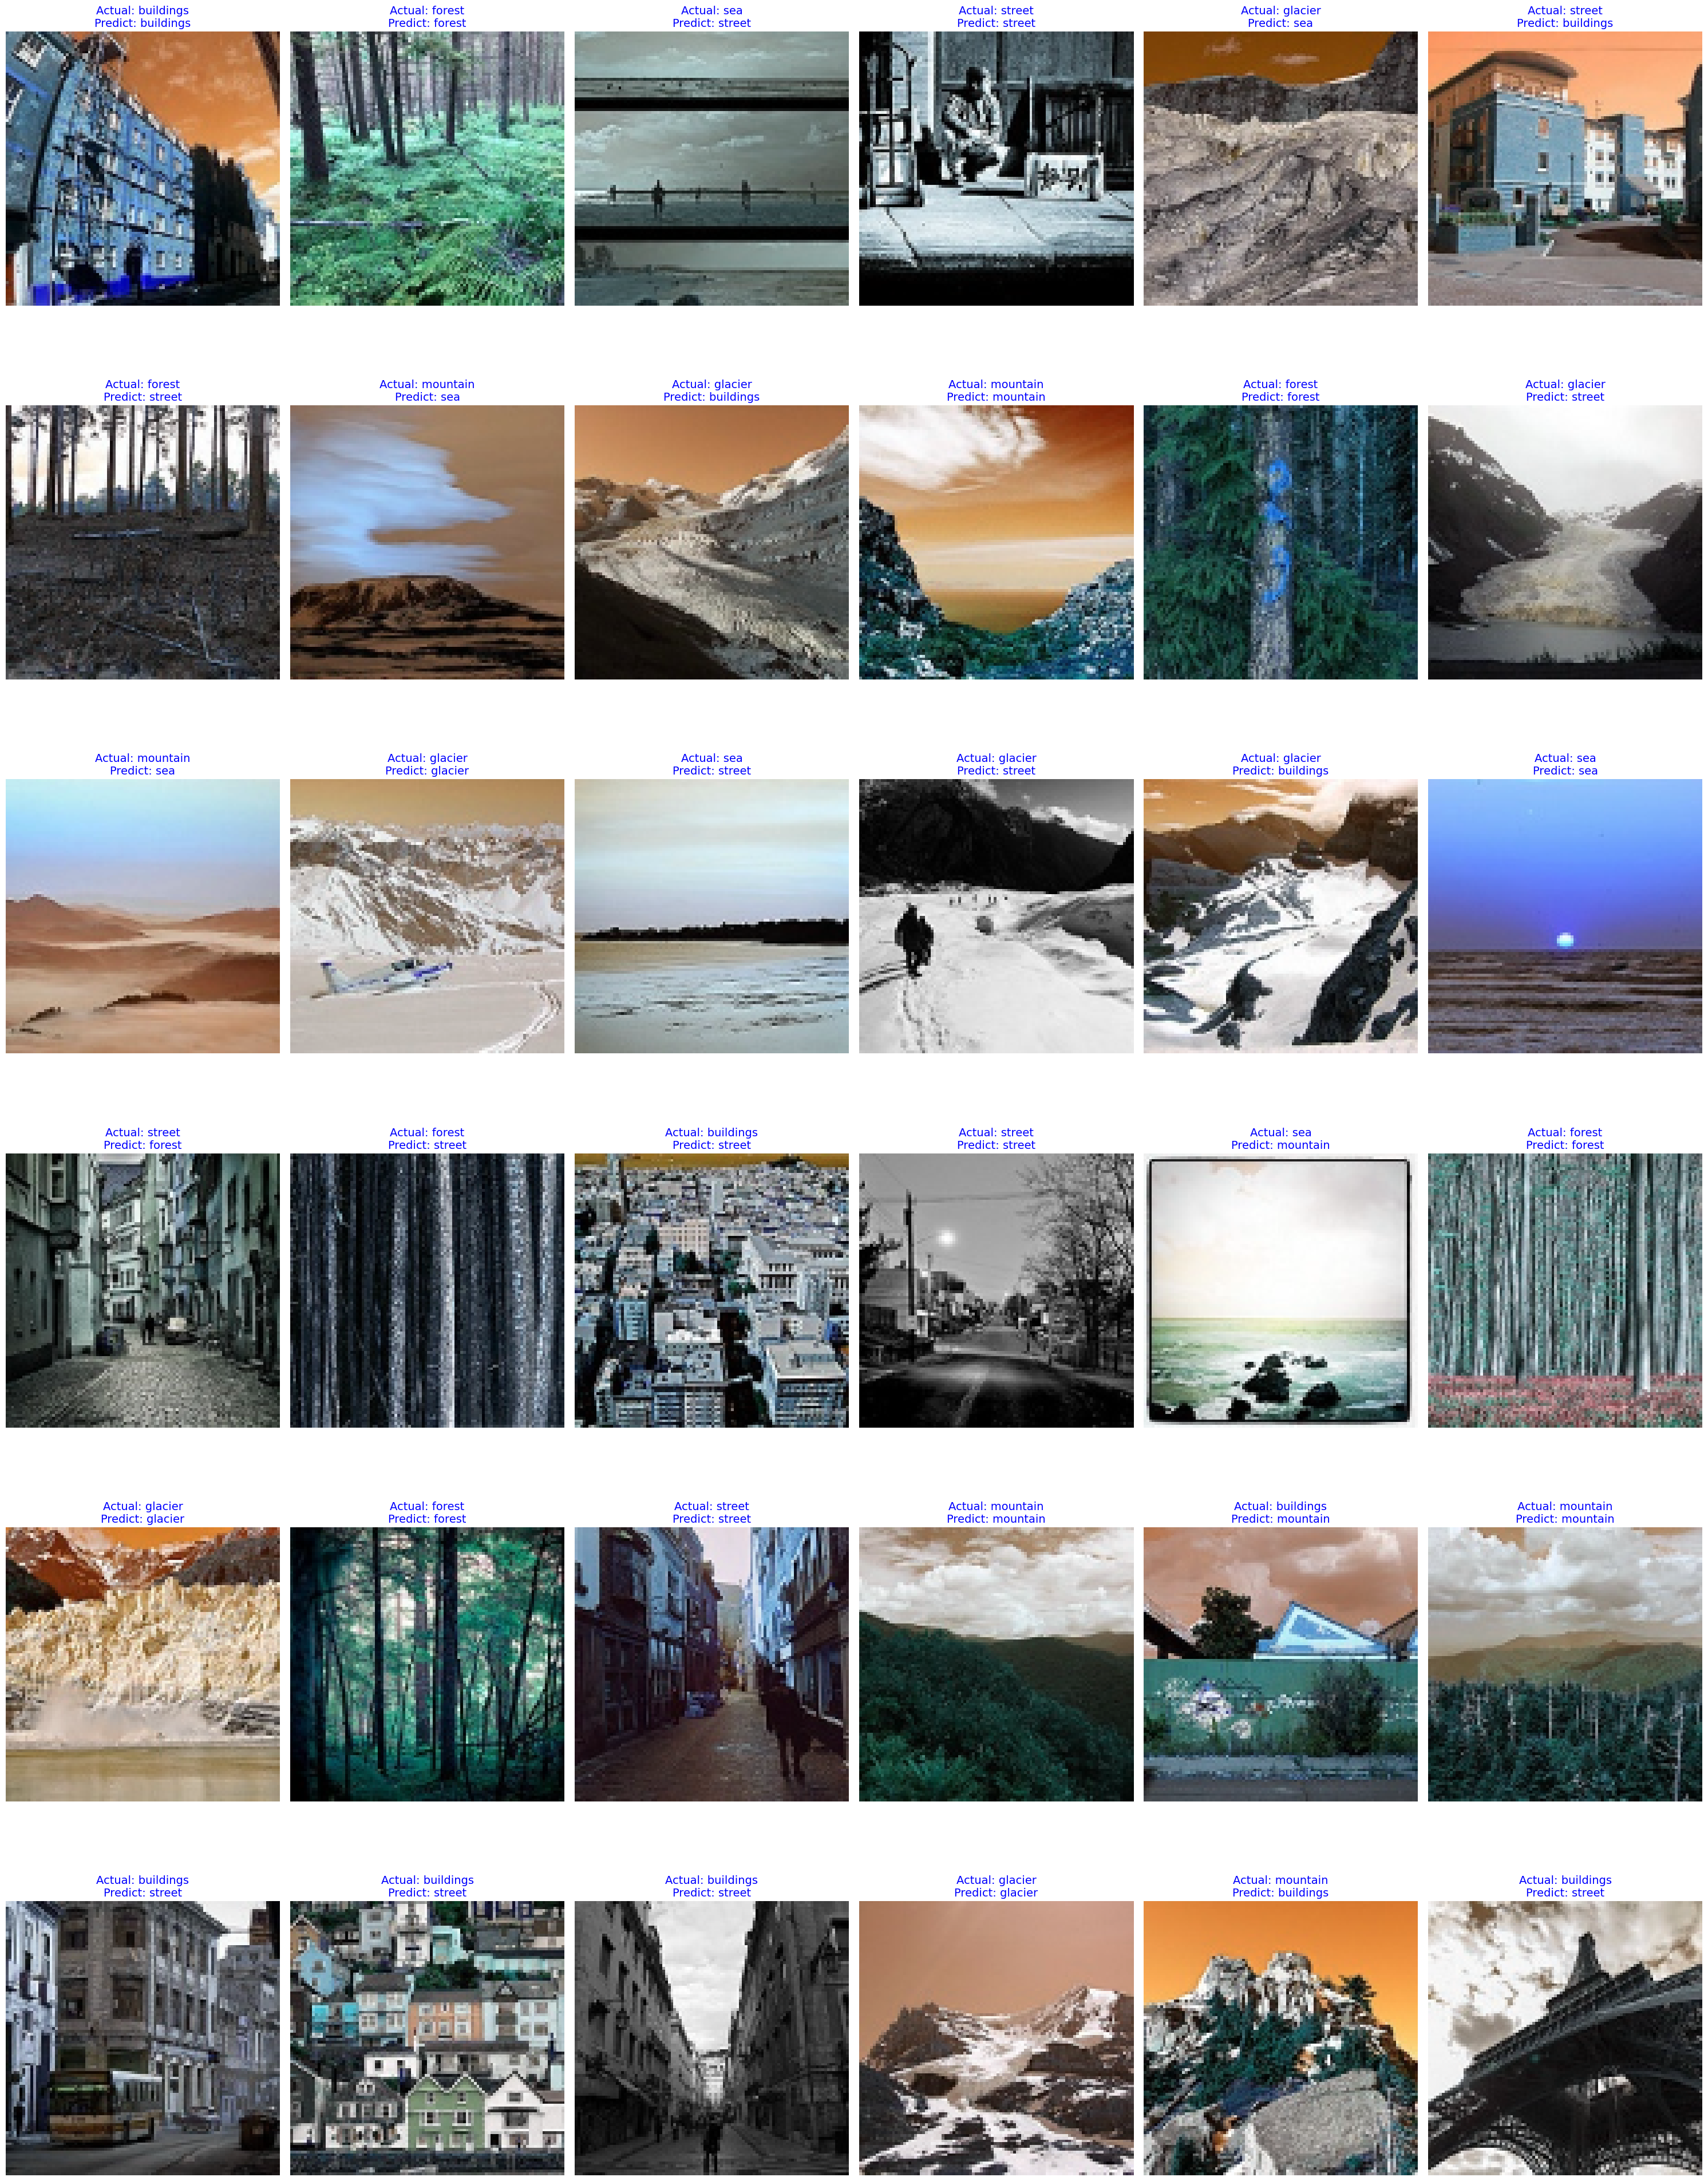

In [ ]:
plt.figure(figsize=(30, 40))

# Randomly select 36 indices
selected_indices = list(np.random.randint(0, len(X_test), 36))

for n, i in enumerate(selected_indices):
    plt.subplot(6, 6, n + 1)

    # Convert the image to a NumPy array and normalize for display
    img = np.array(X_test[i])  # Ensure the image is a NumPy array
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

    plt.imshow(img)
    plt.axis('off')

    # Get actual and predicted labels
    actual_label = get_name(y_test[i])
    predicted_label = get_name(np.argmax(y_test_pred[i].numpy()))

    plt.title(f'Actual: {actual_label}\nPredict: {predicted_label}', fontdict={'fontsize': 14, 'color': 'blue'})

plt.tight_layout()
plt.show()


**3.Calculating Confusion Matrix**

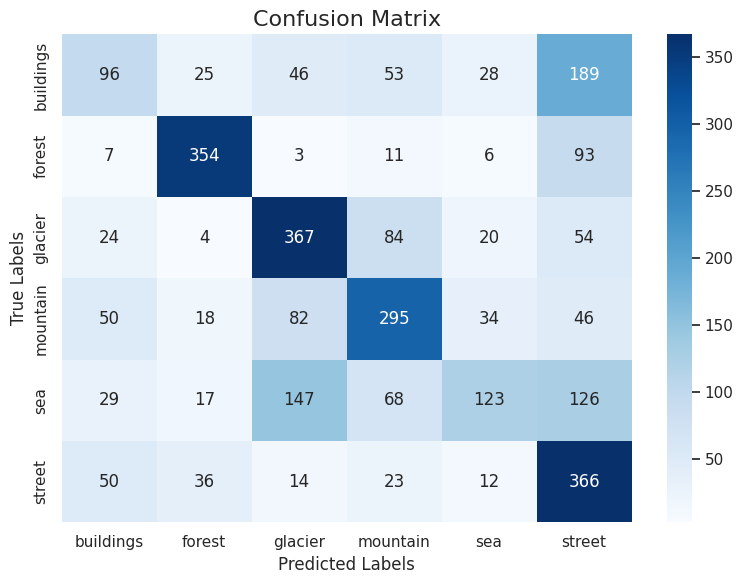

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.tight_layout()
    plt.show()

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
pred_labels = np.argmax(y_test_pred.numpy(), axis=1)
plot_confusion_matrix(y_test, pred_labels, class_names)
